### M Dwarf Flare Metric Implementation 

The MDwarfFlareMetric class is designed to simulate and analyze M Dwarf flares, accounting for both resolved (detectable flares) and unresolved (transient flares) scenarios.

**Key Components of the Code**

**M Dwarf Flare Light Curves:**

The MDwarfFlareLC class generates synthetic light curves for M Dwarf flares in the g, r, i, z, y filters based on realistic rise/fade rates and peak magnitudes.

Light curves are generated for num_samples (100 by default) using a normal distribution for rise and fade rates.

**MDwarf Flare Detection:**

Resolved Detection: A flare is detected if its signal-to-noise ratio (SNR) exceeds certain thresholds (5σ and 3σ). If the detected points are within a single observation night (separated by less than 0.5 days), it is classified as detected.

Unresolved Detection: For flares without a visible counterpart, at least two detections are required, separated by more than 15 minutes, to avoid detecting moving objects.

**Characterization:**

After detecting a flare, its characterization is performed. A flare is classified as:

**Single:** If the flare has a single peak.

**Complex:** If the flare has multiple peaks (with a separation of at least 0.1 days).

**Galactic Latitude Cut:**

A Galactic latitude cut (|b| < 30°) filters flares to simulate only those near the Galactic plane, where M Dwarfs are most common. This is done using the function equatorialFromGalactic, which converts Galactic coordinates to Equatorial coordinates.

**Slicer Generation:**

The slicer (MDwarfFlareSlicer) is responsible for generating flare positions and characteristics. This includes applying the Galactic latitude filter and generating flare properties such as peak_time, distance, and file_index.

**Plotting the Results:**
The MetricBundleGroup class groups multiple metrics (detection, classical, complex, unresolved) and plots the results using a Healpix SkyMap.

The script also provides a mechanism for saving the flare detection and classification results into CSV files (outfile for summary efficiency and typefile for flare classifications).

In [17]:
%matplotlib inline

import glob
import os
import random
import json
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
from local_opsdb_patch import OpsimDatabase #local
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles

#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp

def equatorialFromGalactic(lon, lat):
    gal = Galactic(l=lon * u.deg, b=lat * u.deg)
    equ = gal.transform_to(ICRS)
    return equ.ra.deg, equ.dec.deg

def hpid2RaDec(nside, hpidx):
    theta, phi = hp.pix2ang(nside, hpidx, nest=False)
    ra = np.degrees(phi)
    dec = 90.0 - np.degrees(theta)
    return ra, dec

def healbin(lon, lat, nside=64, nest=False):
    theta = np.radians(90. - lat)
    phi = np.radians(lon)
    return hp.ang2pix(nside, theta, phi, nest=nest)

_healbin = healbin

#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [37]:
##RUN TWICE

import sys
import importlib

if "local_MDwarfFlares" in sys.modules:
    del sys.modules["local_MDwarfFlares"]

import local_MDwarfFlares
importlib.reload(local_MDwarfFlares)

from local_MDwarfFlares import (
    generateMDwarfFlareSlicer,
    MDwarfFlareDetectionMetric,
    MDwarfFlareClassicalMetric,
    MDwarfFlareComplexMetric,
    MDwarfFlareUnresolvedMetric,
    MDwarfFlareResolvedMetric
)
print(local_MDwarfFlares.__file__)

from rubin_sim.phot_utils import DustValues
print(DustValues.__module__)



/Users/andradenebula/Documents/Research/Transient_Metrics/Stuff/AllTransient/local_MDwarfFlares.py
rubin_sim.phot_utils.photometric_parameters


In [38]:
# ------------------------------------
# Script Configuration
# ------------------------------------
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
filters = ['g', 'r', 'i', 'z', 'y']

rate_deg2_hr = 1.0         # Flare rate per deg^2 per hr
max_events = 100000        # Cap number of flares injected
gal_lat_cut = 30           # Galactic latitude cut
delta_mag = 5.0            # Flare peak offset from quiescence (mag)

dmin = 10                  # Placeholder distance parameters
dmax = 1000

mdwarf_pop_file = "MDwarf_population.pkl"

# ------------------------------------
# Load or Generate the M Dwarf Flare Population
# ------------------------------------
if os.path.exists(mdwarf_pop_file):
    slicer = generateMDwarfFlareSlicer(load_from=mdwarf_pop_file)
else:
    slicer = generateMDwarfFlareSlicer(
        t_start=1, t_end=3652, seed=42,
        rate_deg2_hr=rate_deg2_hr,
        max_events=max_events,
        gal_lat_cut=gal_lat_cut,
        save_to=mdwarf_pop_file
    )

n_events = len(slicer.slice_points['peak_time'])

print(f"Total M Dwarf Flare events simulated: {n_events}")
print(f"First few peak times (days): {slicer.slice_points['peak_time'][:5]}")

# ------------------------------------
# Run Metrics Per Cadence
# ------------------------------------
for cadence in cadences:
    print(f"\n--- Running Cadence: {cadence} ---")
    db_path = f"{cadence}.db"
    opsdb = db_path

    outDir = "AllTransient_MetricDetection/MDwarfFlares/Metric_temp"
    resultsDb = db.ResultsDb(out_dir=outDir)

    outfile_eff = f"AllTransient_MetricDetection/MDwarfFlares/efficiency_{cadence}_mdwarf.csv"
    outfile_type = f"AllTransient_MetricDetection/MDwarfFlares/types_{cadence}_mdwarf.csv"

    os.makedirs(outDir, exist_ok=True)

    # Define per-filter metrics
    per_filter_metrics = OrderedDict()

    for filt in filters:
        detect = MDwarfFlareDetectionMetric(metricName=f"MDwarfFlare_Detect_{filt}", filter_include=[filt])
        classical = MDwarfFlareClassicalMetric(metricName=f"MDwarfFlare_Classical_{filt}", filter_include=[filt])
        complexflare = MDwarfFlareComplexMetric(metricName=f"MDwarfFlare_Complex_{filt}", filter_include=[filt])

        per_filter_metrics[f"MDwarfFlare_Detect_{filt}"] = metric_bundles.MetricBundle(detect, slicer, '')
        per_filter_metrics[f"MDwarfFlare_Classical_{filt}"] = metric_bundles.MetricBundle(classical, slicer, '')
        per_filter_metrics[f"MDwarfFlare_Complex_{filt}"] = metric_bundles.MetricBundle(complexflare, slicer, '')

    # Bundle group and run
    pf_group = metric_bundles.MetricBundleGroup(per_filter_metrics, opsdb, out_dir=outDir, results_db=resultsDb)
    pf_group.run_all()

    # ------------------------------------
    # Plot Healpix Detection Maps
    # ------------------------------------
    print(f"--- Plotting Healpix maps for {cadence} ---")

    import healpy as hp

    nside = slicer.nside if hasattr(slicer, 'nside') else 64
    npix = hp.nside2npix(nside)

    # Prepare injected flare map
    ra = slicer.slice_points['ra']
    dec = slicer.slice_points['dec']
    theta = np.radians(90.0 - dec)
    phi = np.radians(ra)
    pix_inds = hp.ang2pix(nside, theta, phi)

    injected_map = np.zeros(npix)
    for pix in pix_inds:
        injected_map[pix] += 1

    # Loop over metrics to plot detection efficiency maps
    for key in ['MDwarfFlare_Detect', 'MDwarfFlare_Classical', 'MDwarfFlare_Complex']:
        for filt in filters:
            metric_key = f"{key}_{filt}"
            if metric_key not in per_filter_metrics:
                continue

            values = per_filter_metrics[metric_key].metric_values
            mask = ~values.mask if hasattr(values, 'mask') else np.ones(len(values), dtype=bool)

            detected_map = np.zeros(npix)
            for i, pix in enumerate(pix_inds):
                if mask[i] and values[i] == 1:
                    detected_map[pix] += 1

            eff_map = np.zeros(npix)
            valid = injected_map > 0
            eff_map[valid] = detected_map[valid] / injected_map[valid]
            eff_map[~valid] = hp.UNSEEN

            title = f"{cadence} – {key}_{filt} Efficiency"

            hp.mollview(eff_map, title=title, unit='Efficiency', cmap='plasma', min=0, max=1)
            hp.graticule()
            plt.show()


    # ------------------------------------
    # Save Efficiency Summary
    # ------------------------------------
    with open(outfile_eff, "w") as out:
        out.write("dist_min_Mpc, dist_max_Mpc, metric, filter, found, total, efficiency\n")
        for key in per_filter_metrics:
            filt = key.split('_')[-1]
            values = per_filter_metrics[key].metric_values
            mask = ~values.mask if hasattr(values, 'mask') else np.ones(len(values), dtype=bool)

            if "Detect" in key:
                found = np.sum((values == 1) & mask)
                total = len(values)
            else:
                detect_key = key.replace("Classical", "Detect").replace("Complex", "Detect")
                if detect_key not in per_filter_metrics:
                    continue
                detect_values = per_filter_metrics[detect_key].metric_values
                detect_mask = ~detect_values.mask if hasattr(detect_values, 'mask') else np.ones(len(detect_values), dtype=bool)
                detected = (detect_values == 1) & detect_mask

                found = np.sum((values == 1) & detected & mask)
                total = np.sum(detected & mask)

            efficiency = found / total if total > 0 else 0.0
            metric_base = key.replace(f"_{filt}", "")
            out.write(f"{dmin}, {dmax}, {metric_base}, {filt}, {found}, {total}, {efficiency:.4f}\n")

    print(f"Wrote efficiency summary to {outfile_eff}")

    # ------------------------------------
    # Save Per-Event Type Classifications
    # ------------------------------------
    with open(outfile_type, "w") as out:
        out.write("index,n_filters_detected,n_filters_classical,n_filters_complex\n")
        for i in range(n_events):
            d = sum(per_filter_metrics[f"MDwarfFlare_Detect_{f}"].metric_values[i] == 1 and not per_filter_metrics[f"MDwarfFlare_Detect_{f}"].metric_values.mask[i] for f in filters)
            c = sum(per_filter_metrics[f"MDwarfFlare_Classical_{f}"].metric_values[i] == 1 and not per_filter_metrics[f"MDwarfFlare_Classical_{f}"].metric_values.mask[i] for f in filters)
            x = sum(per_filter_metrics[f"MDwarfFlare_Complex_{f}"].metric_values[i] == 1 and not per_filter_metrics[f"MDwarfFlare_Complex_{f}"].metric_values.mask[i] for f in filters)

            out.write(f"{i},{d},{c},{x}\n")

    print(f"Wrote per-event flare type classification to {outfile_type}")

Applied Galactic latitude cut: |b| < 30 deg
Saved flare population to MDwarf_population.pkl
Total M Dwarf Flare events simulated: 998771
First few peak times (days): [1368.44597391 3472.0579327  2673.50988155 2186.7021258   570.62405626]
DEBUG: Metrics in bgroup
 - BaseMDwarfFlare_Detection
 - MDwarfFlare_Classical
 - MDwarfFlare_Complex
 - MDwarfFlare_Unresolved
 - MDwarfFlare_Resolved


Plotting: BaseMDwarfFlare_Detection


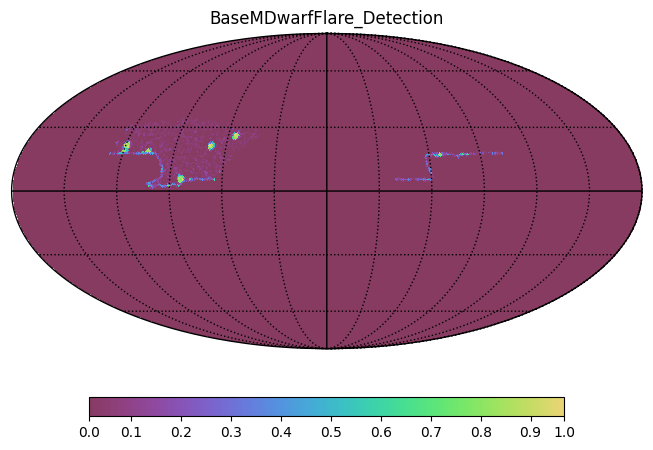

Plotting: MDwarfFlare_Classical


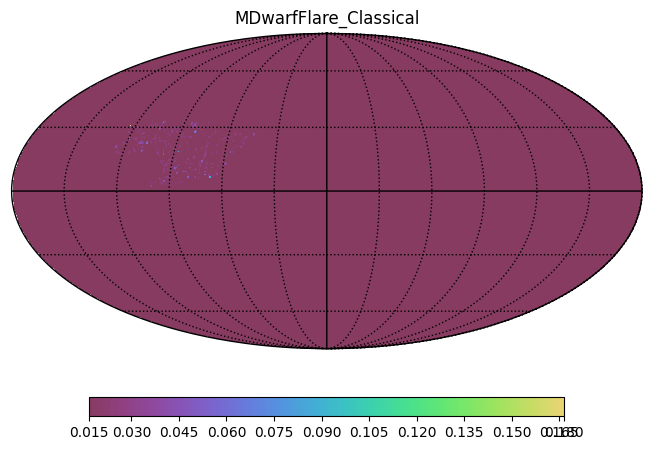

Plotting: MDwarfFlare_Complex


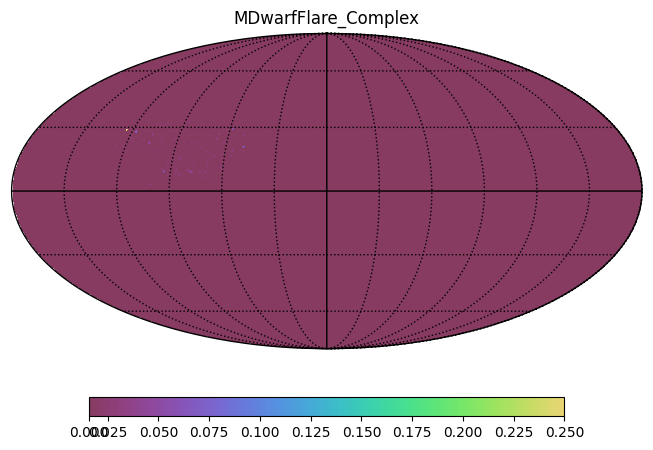

Plotting: MDwarfFlare_Unresolved


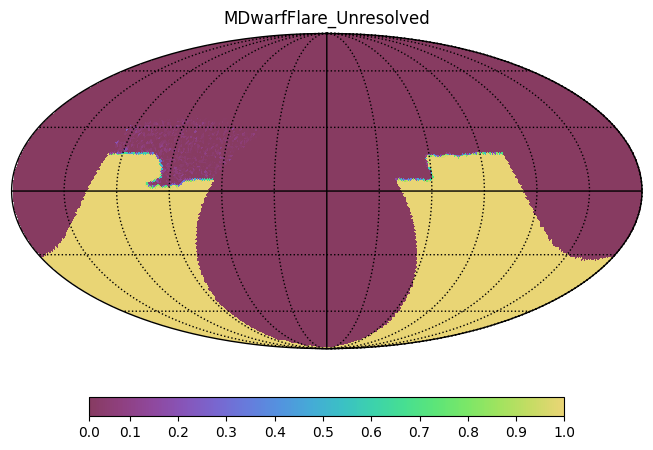

Plotting: MDwarfFlare_Resolved


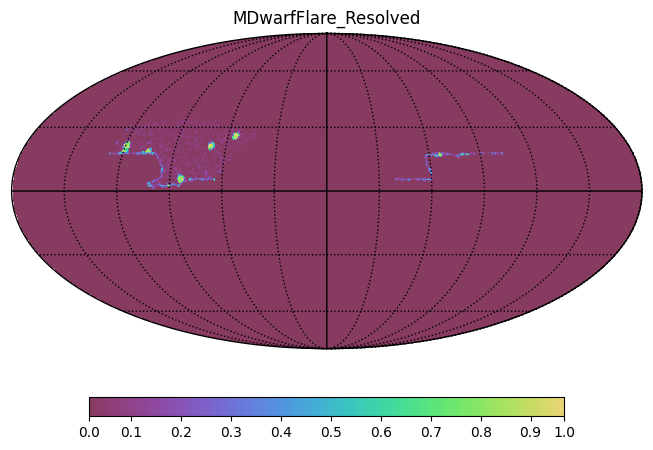

In [39]:
from rubin_sim.maf.plots import HealpixSkyMap
import matplotlib.pyplot as plt

# Initialize the plotter
plotter = HealpixSkyMap()

# Loop through the metrics and check if they are numeric before plotting
for key, bundle in bd.items():
    # Ensure that the metric values are numeric
    if isinstance(bundle.metric_values, np.ndarray) and np.issubdtype(bundle.metric_values.dtype, np.number):
        print(f"Plotting: {key}")
        plotter(
            bundle.metric_values,
            slicer=bundle.slicer,
            user_plot_dict=bundle.plot_dict
        )
        plt.title(key)
        plt.show()
    else:
        print(f"Skipping: {key} — metric values are not numeric or are missing.")


In [40]:
import pickle

# Path to your saved file
filename = 'MDwarf_population.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)

# Example: print the keys and the first few values
print(data.keys())
for key in data:
    print(f"{key}[:5] = {data[key][:5]}")


dict_keys(['ra', 'dec', 'peak_time', 'file_indx', 'distance', 'ebv'])
ra[:5] = [278.62417746 309.09525114 274.0102927  282.98314988 296.19418075]
dec[:5] = [ 40.72841417  12.63775518 -28.2027822  -28.47485067 -24.62877529]
peak_time[:5] = [1368.44597391 3472.0579327  2673.50988155 2186.7021258   570.62405626]
file_indx[:5] = [72 62  0 56 61]
distance[:5] = [1. 1. 1. 1. 1.]
ebv[:5] = [0.07160125 0.07506447 0.10391264 0.03255146 0.01625561]
